# Ciencia de datos de clasificación

Importar librerías

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report,roc_auc_score, roc_curve)
from imblearn.under_sampling import RandomUnderSampler

Importar datos limpios

In [122]:
df=pd.read_csv("listings_limpio.csv")

# Alistamiento de datos

Visualizar dataframe

In [123]:
df.drop(columns=['id'], inplace=True)
df.shape

(17664, 39)

Definir el target

In [124]:
df['Target']= (df['review_scores_rating']>=4.8).astype(int)
df['Target'].value_counts()


Target
0    11341
1     6323
Name: count, dtype: int64

Borrar la variable que se usó para definir el target

In [125]:
cols_review= [c for c in df.columns if "review_scores" in c]
cols_review

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [126]:
df.drop(columns=cols_review, inplace=True)

In [127]:
df.drop(columns='neighbourhood_cleansed', inplace=True)
df.drop(columns='reviews_per_month', inplace=True)
df.drop(columns='estimated_occupancy_l365d', inplace=True)
df.drop(columns='estimated_revenue_l365d', inplace=True)
df.drop(columns='minimum_nights', inplace=True)
df.drop(columns='maximum_nights', inplace=True)
df.drop(columns='number_of_reviews', inplace=True)
df.drop(columns='host_response_rate', inplace=True)
df.drop(columns='host_acceptance_rate', inplace=True)

### Ordenar feats

In [128]:
cols_string = df.select_dtypes(include=['object', 'string']).columns.tolist()

In [129]:
cols_bool = df.select_dtypes(include=['bool']).columns.tolist()
df[cols_bool] = df[cols_bool].astype(int)

In [130]:
cols_num = df.select_dtypes(include=['number']).columns.tolist()
cols_num.remove('Target')
cols_bin= [
    c for c in cols_num
    if df[c].dropna().nunique() == 2 and df[c].dropna().isin([0, 1]).all()
]
cols_num=[c for c in cols_num if c not in cols_bin]

In [131]:
feats = cols_num+cols_bin+cols_string
print(len(feats),feats)

23 ['latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'availability_365', 'Wifi', 'Air_conditioning', 'Kitchen_and_dining', 'Washer_dryer', 'TV', 'Safe', 'Refrigerator', 'Smoke_alarm_home_safety', 'Essentials', 'Services', 'property_Entire_Place', 'property_Hotel_Room', 'property_Other', 'property_Private_Room', 'property_Shared_Room']


In [132]:
df=df[feats+['Target']]
df.head(5)

,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,availability_365,Wifi,Air_conditioning,...,Refrigerator,Smoke_alarm_home_safety,Essentials,Services,property_Entire_Place,property_Hotel_Room,property_Other,property_Private_Room,property_Shared_Room,Target
0,40.41476,-3.70418,2,1.0,1.0,2.0,157.0,342,1,1,...,0,0,0,0,1,0,0,0,0,0
1,40.42247,-3.70577,2,1.0,1.0,3.0,143.0,341,1,1,...,0,0,0,0,1,0,0,0,0,0
2,40.41884,-3.69655,4,1.5,1.0,2.0,65.0,299,1,0,...,1,1,1,0,0,0,0,1,0,0
3,40.42252,-3.70250,2,1.0,1.0,1.0,116.0,305,1,1,...,1,0,1,1,1,0,0,0,0,0
4,40.42252,-3.70250,2,1.0,1.0,2.0,79.0,317,1,1,...,1,0,1,1,1,0,0,0,0,0


### Separar en train y test

In [133]:
train = df.sample(frac=0.8, random_state=100)
x_train=train.drop(columns=df.columns[-1])
x_train.head()
y_train=train['Target']

In [134]:
test = df.drop(train.index)
x_test=test.drop(columns=df.columns[-1])
x_test.head()
y_test=test['Target']

In [135]:
val = train.sample(frac=0.2, random_state=100)
train = train.drop(val.index)

In [136]:
print(train.shape)
print(val.shape)
print(test.shape)

(11305, 24)
(2826, 24)
(3533, 24)


### Balancear train

In [137]:
rus = RandomUnderSampler(random_state=42)
x_train, y_train = rus.fit_resample(x_train, y_train)
print(y_train.value_counts())

Target
0    5071
1    5071
Name: count, dtype: int64


### Procesar variables de entrada

In [138]:
def dataframe_to_dataset(dataframe, shuffle=True):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)
    return ds

In [139]:
batch_size = 32

train_ds = dataframe_to_dataset(train, shuffle=True).batch(batch_size)
val_ds   = dataframe_to_dataset(val, shuffle=False).batch(batch_size)
test_ds  = dataframe_to_dataset(test, shuffle=False).batch(batch_size)

In [140]:
def encode_numerical_feature(feature, name, dataset):
    normalizer = keras.layers.Normalization()
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    normalizer.adapt(feat_ds)
    return normalizer(feature)

def encode_categorical_feature(feature, name, dataset, is_string=False):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    lookup = lookup_class(output_mode="binary")  
    feat_ds = dataset.map(lambda x, y: x[name])
    feat_ds = feat_ds.map(lambda x: tf.expand_dims(x, -1))
    lookup.adapt(feat_ds)
    return lookup(feature)

In [141]:
inputs = []
for i in cols_num:
  inputs.append(keras.Input(shape=(1,), name=i))

for i in cols_bin:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="int64"))

for i in cols_string:
  inputs.append(keras.Input(shape=(1,), name=i, dtype="string"))

In [142]:
feats_encoded=[]
len_feats=len(feats_encoded)
for i,feat in enumerate(cols_num):
  feats_encoded.append(
      encode_numerical_feature(inputs[len_feats+i], feat, train_ds)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_bin):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, False)
  )

len_feats=len(feats_encoded)

for i,feat in enumerate(cols_string):
  feats_encoded.append(
      encode_categorical_feature(inputs[len_feats+i], feat, train_ds, True)
  )

all_feats = keras.layers.concatenate(feats_encoded)
len_feats

23

## Red neuronal de clasificación

### Contruir modelo

In [143]:
capa1= keras.layers.Dense(64, activation='relu')(all_feats)
capa2 = keras.layers.Dense(64, activation='relu')(capa1)
model_layers = keras.layers.Dense(1, activation='sigmoid')(capa2)
model = keras.Model(inputs, model_layers)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 latitude (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 longitude (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 accommodates (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 bathrooms (InputLayer)      [(None, 1)]                  0         []                            
                                                                                            

In [144]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [145]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [146]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

### Entrenar modelo

In [147]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

Epoch 1/50
354/354 [==============================] - 2s 3ms/step - loss: 0.6338 - accuracy: 0.6432 - val_loss: 0.6217 - val_accuracy: 0.6564
Epoch 2/50
354/354 [==============================] - 1s 2ms/step - loss: 0.6225 - accuracy: 0.6537 - val_loss: 0.6187 - val_accuracy: 0.6539
Epoch 3/50
354/354 [==============================] - 1s 2ms/step - loss: 0.6170 - accuracy: 0.6556 - val_loss: 0.6198 - val_accuracy: 0.6571
Epoch 4/50
354/354 [==============================] - 1s 2ms/step - loss: 0.6127 - accuracy: 0.6617 - val_loss: 0.6171 - val_accuracy: 0.6578
Epoch 5/50
354/354 [==============================] - 1s 2ms/step - loss: 0.6083 - accuracy: 0.6654 - val_loss: 0.6142 - val_accuracy: 0.6663
Epoch 6/50
354/354 [==============================] - 1s 2ms/step - loss: 0.6058 - accuracy: 0.6670 - val_loss: 0.6182 - val_accuracy: 0.6621
Epoch 7/50
354/354 [==============================] - 1s 2ms/step - loss: 0.6015 - accuracy: 0.6700 - val_loss: 0.6137 - val_accuracy: 0.6617
Epoch 

### Metricas

Historial de pérdida

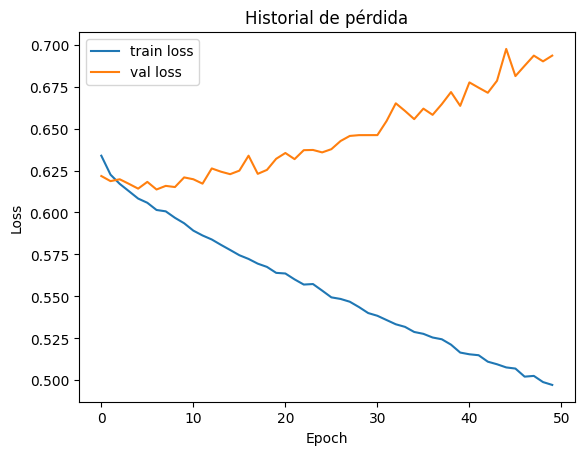

In [151]:
# Pérdida
plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Historial de pérdida")
plt.legend(); plt.show()


Predicción

In [149]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob>0.5).astype(int)
y_pred
y_pred.shape

111/111 [==============================] - 0s 1ms/step


(3533, 1)

Metricas

111/111 [==============================] - 0s 997us/step
Accuracy : 0.6589300877441268
Precision: 0.636879267897234
Recall   : 0.6589300877441268
F1       : 0.6353800684852273
ROC-AUC  : 0.584888290965932

Matriz de confusión:
 [[1914  367]
 [ 838  414]]

Reporte de clasificación:
                 precision    recall  f1-score   support

no-recomendado       0.70      0.84      0.76      2281
   recomendado       0.53      0.33      0.41      1252

      accuracy                           0.66      3533
     macro avg       0.61      0.58      0.58      3533
  weighted avg       0.64      0.66      0.64      3533

Especificidad(TNR): 0.8391
Error tipo I (FPR): 0.1609
Error tipo II(FNR): 0.6693


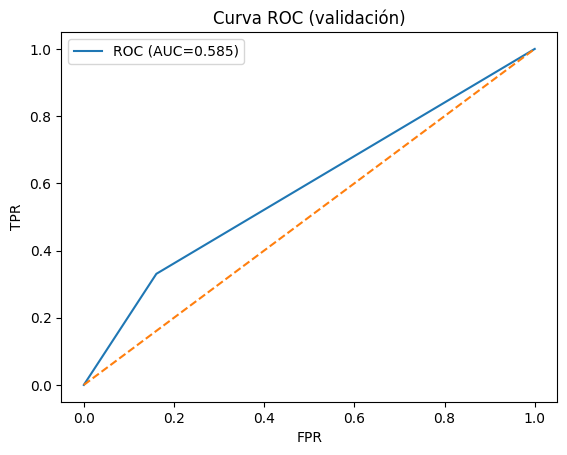

In [150]:
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob>0.5).astype(int).flatten()
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

acc  = accuracy_score(y_true,y_pred)
prec = precision_score(y_true,y_pred, average='weighted', pos_label=1)
rec  = recall_score(y_true,y_pred, pos_label=1,average='weighted')
f1   = f1_score(y_true,y_pred, pos_label=1,average='weighted')
cm   = confusion_matrix(y_true,y_pred)
report = classification_report(y_true,y_pred, target_names=["no-recomendado","recomendado"])

tn, fp, fn, tp = confusion_matrix(y_true,y_pred, labels=[0,1]).ravel()
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0      
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0 
# ROC-AUC (prob de la clase positiva = columna 1)
auc  = roc_auc_score(y_true,y_pred)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1       :", f1)
print("ROC-AUC  :", auc)
print("\nMatriz de confusión:\n", cm)
print("\nReporte de clasificación:\n", report)
print(f"Especificidad(TNR): {tnr:.4f}")
print(f"Error tipo I (FPR): {fpr:.4f}")
print(f"Error tipo II(FNR): {fnr:.4f}")

# ===== 5) Curva ROC (opcional en el reporte) =====
fpr, tpr, thr = roc_curve(y_true,y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC (validación)")
plt.legend(); plt.show()